In [23]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Mass_richness_relation as mass_richness
import analysis_Mass_Richness_relation as analysis



import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
Nfw = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/MCMC_chains/nfw_Diemer15_true.pkl', allow_pickle=True)
Einasto = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/MCMC_chains/einasto_Duffy08Einasto_true_1h.pkl', allow_pickle=True)

In [25]:
label_plot = Einasto['label']

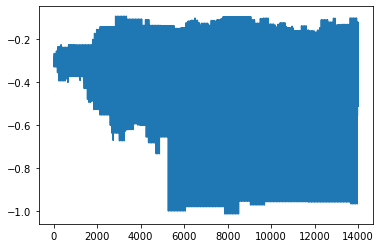

In [34]:
plt.plot(Einasto['chains'][:,1])

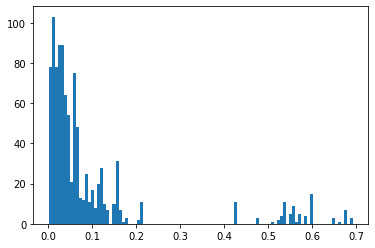

In [57]:
plt.hist(Einasto['chains'][:,3][13000:], bins=100)
plt.show()

In [28]:
k = Diemer15['chains']
a = len(k)
middle = np.mean(k[10000:a-1], axis = 0)
std = np.std(k[10000:a-1], axis = 0)
range_corner_plot = [(middle[i]- 4 * std[i], middle[i]+ 4 * std[i]) for i in range(4)]
range_corner_plot[-1] = (0,.5)

In [29]:
#plt.rcParams['axes.linewidth'] = 1
#label_contours = ['Diemer15', 'Prada12', 'Duffy08','Bhattacharya13']
#labels_param = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
#sigma1 = 1. - np.exp(-(1./1.)**2/2.)
#sigma2 = 1. - np.exp(-(2./1.)**2/2.)
#sigma3 = 1. - np.exp(-(3./1.)**2/2.)
#truth = [14.162, -0.23, 0.8]
#bins = 12
#c = ['orange', 'r', 'm', 'k','k']
#show = [True, True, True, True, True]
#fill_contours = [False, False, False, False,  False]
#fig, axs = plt.subplots(4,4, figsize = (7,7))

#for i,sample in enumerate([ Diemer15, Prada12, Duffy08,Bhattacharya13 ]):
#    s = sample['chains'][13000:]
#    fig = corner.corner(
#    s[(s[:,3]>.0)*(s[:,1]>-.48)],fig=fig,smooth=True, smooth1d=True,
#    bins=bins, levels=(sigma1, sigma2), color=c[i],fill_contours=False,
 #       plot_datapoints=False,
#        range=range_corner_plot,plot_density=False, title = label_contours[i],
 #       #truths = [14.14658711, -0.33866985,  0.80118873,  0.46037449],
 #   labels = label_plot);
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
#plt.legend()
#plt.savefig('effect_modelling_mass_concentration.png', bbox_inches='tight', dpi=300)

In [30]:
label_contours = ['nfw', 'Einasto']
labels_param = [r'\log_{10}(M_{0})', r'G_z',r'F_\lambda', r'\sigma_{\ln M|\lambda}']
names = ['1', '2', '3', '4',]
samples = [ Nfw, Einasto ]

In [52]:
import getdist
from getdist import plots, MCSamples
ndim=4
settings={'mult_bias_correction_order':0,'smooth_scale_2D':3, 'smooth_scale_1D':3, 'boundary_correction_order':0}
sample_list = []
for i, s in enumerate(samples):
    scut = s['chains'][13000:]
    scut = scut[(scut[:,1]<-.2)*(scut[:,1]<0)*(scut[:,3]>0)]
    print(scut.shape)
    samples_format = MCSamples(samples=scut,names = names, 
                    labels = labels_param, settings=settings, label=label_contours[i])
    sample_list.append(samples_format)

fiducial_sample = np.load('fiducial_sample.txt.npy')
samples_format = MCSamples(samples=fiducial_sample, names = names, 
                    labels = labels_param, settings=settings, label='Fiducial')
sample_list.append(samples_format)

(998, 4)
Removed no burn in
(756, 4)
Removed no burn in
Removed no burn in


In [53]:
range_corner_plot = {n:[middle[i]- 5*std[i], middle[i]+ 5*std[i]] for i, n in enumerate(names)}
range_corner_plot['4'] = [0, .5]

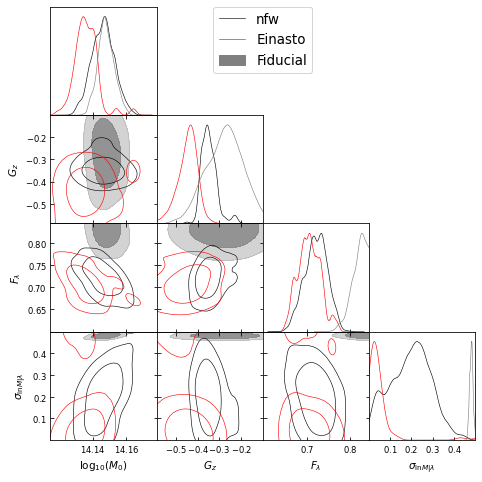

In [56]:
g = plots.get_subplot_plotter(subplot_size=1.7)
g.settings.axes_fontsize = 12
g.settings.legend_fontsize = 17
g.triangle_plot(sample_list, param_limits = range_corner_plot, filled=[False,False,True,False,True], 
                       fine_bins = 1,  marker_args = {'linewidth':2}, contour_colors = ['black', 'red', 'grey', 'green', 'grey' ])
# plt.savefig('effect_of_cm.png', bbox_inches='tight', dpi=300)